## IMPORT LIBRARIES

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bisect
from sklearn.preprocessing import *
import mpl_toolkits.mplot3d 
from sklearn.cluster import KMeans

In [72]:
# Define a function to calculate the ulcer index
def m_ulcer_index(series):
    drawdown = (series - series.cummax()) / series.cummax()
    squared_average = (drawdown ** 2).mean()
    return squared_average ** 0.5

In [73]:
# dist_measure
# 1 = Euclidean Distance
# 2 = Perpendicular Distance
# 3 = Vertical Distance
def find_pips(data: np.array, n_pips: int, dist_measure: int):
    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):
        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1
        # Use a single loop to iterate over all the points
        for i in range(1, len(data) - 1):
            left_adj = bisect.bisect_right(pips_x, i) - 1
            right_adj = left_adj + 1
            # Calculate the distance from the point to the line segment
            d = distance(data, pips_x, pips_y, i, left_adj, right_adj, dist_measure)
            # Update the maximum distance and the insert index
            if d > md:
                md = d
                md_i = i
                insert_index = right_adj
        # Insert the new pip
        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])
    return pips_x, pips_y

# Define a helper function to calculate the distance
def distance(data, pips_x, pips_y, i, left_adj, right_adj, dist_measure):
    time_diff = pips_x[right_adj] - pips_x[left_adj]
    price_diff = pips_y[right_adj] - pips_y[left_adj]
    slope = price_diff / time_diff
    intercept = pips_y[left_adj] - pips_x[left_adj] * slope
    dist_funcs = {
        1: lambda x, y: ( (pips_x[left_adj] - x) ** 2 + (pips_y[left_adj] - y) ** 2 ) ** 0.5 + ( (pips_x[right_adj] - x) ** 2 + (pips_y[right_adj] - y) ** 2 ) ** 0.5,
        2: lambda x, y: abs( (slope * x + intercept) - y ) / (slope ** 2 + 1) ** 0.5,
        3: lambda x, y: abs( (slope * x + intercept) - y )
    }
    return dist_funcs[dist_measure](i, data[i])

In [74]:

data = pd.read_csv("/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data/GBP_USD_M15_raw_data.csv", parse_dates=['time'])
data = data.set_index('time')
# take data from 2007 to 2014
data = data['2007-01-01':'2008-01-01']

# add new columns from the time column, year, month, day, hour, minute
data['year'] = data.index.year
data['month'] = data.index.month
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour
data['minute'] = data.index.minute
data

,open,high,low,close,volume,year,month,day_of_week,hour,minute
time,,,,,,,,,,
2007-01-01 21:30:00+00:00,1.95840,1.95860,1.95840,1.95840,18,2007,1,0,21,30
2007-01-01 21:45:00+00:00,1.95840,1.95965,1.95830,1.95920,47,2007,1,0,21,45
2007-01-01 22:00:00+00:00,1.95910,1.96005,1.95890,1.95978,60,2007,1,0,22,0
2007-01-01 22:15:00+00:00,1.96003,1.96190,1.96003,1.96156,91,2007,1,0,22,15
2007-01-01 22:30:00+00:00,1.96138,1.96174,1.96083,1.96174,82,2007,1,0,22,30
...,...,...,...,...,...,...,...,...,...,...
2008-01-01 22:45:00+00:00,1.98707,1.98725,1.98661,1.98670,45,2008,1,1,22,45
2008-01-01 23:00:00+00:00,1.98670,1.98905,1.98670,1.98905,71,2008,1,1,23,0
2008-01-01 23:15:00+00:00,1.98868,1.98965,1.98868,1.98940,90,2008,1,1,23,15


In [75]:
n_close_points = 24
n_perc_points = 5
dist_measure = 1
pips_y_list = []
future_candles = 10
# loop through the data
# start from the 24th point
for index in range(n_close_points, len(data)):
    try:
        x_close = data['close'].iloc[index-n_close_points:index].to_numpy()
        pips_x, pips_y = find_pips(x_close, n_perc_points, dist_measure)
        scaled_pips_y = StandardScaler().fit_transform(np.array(pips_y).reshape(-1, 1)).reshape(-1)
        pips_y_dict = {f'pip_{i}': scaled_pips_y[i] for i in range(n_perc_points)}
        j = index - 1
        pips_y_dict['year'] = data['year'].iloc[j]
        pips_y_dict['month'] = data['month'].iloc[j]
        pips_y_dict['day_of_week'] = data['day_of_week'].iloc[j]
        pips_y_dict['hour'] = data['hour'].iloc[j]
        pips_y_dict['minute'] = data['minute'].iloc[j]
        pips_y_dict['close'] = data['close'].iloc[j]
        pips_y_dict['current_log_ratio'] = 2500 * np.log(pips_y_dict['close'] / data['close'].iloc[j-1])
        # future features
        pips_y_dict['future_close'] = data['close'].iloc[j+future_candles]
        pips_y_dict['future_return'] = pips_y_dict['future_close'] - pips_y_dict['close']
        pips_y_dict['future_log_ratio'] = 2500 * np.log(pips_y_dict['future_close'] / pips_y_dict['close'])
        pips_y_list.append(pips_y_dict)
    except:
        print('An exception occurred')
        break

pips_y_df = pd.DataFrame(pips_y_list)
pips_y_df_np = pips_y_df.to_numpy()

An exception occurred


In [76]:
np.random.seed(5)
# standard scale the 'hour', 'minute', 'current_log_ratio' columns
pips_y_df[['day_of_week', 'hour', 'minute']] = StandardScaler().fit_transform(pips_y_df[['day_of_week', 'hour', 'minute']])
pips_y_df_np = pips_y_df[['pip_0', 'pip_1', 'pip_2', 'pip_3', 'pip_4', 'day_of_week', 'hour', 'minute']].to_numpy()
kmeans = KMeans(n_clusters=36)
kmeans.fit(pips_y_df_np)
pips_y_df['k_label'] = kmeans.labels_
train_pips_y_df = pips_y_df.copy()

In [77]:
# k_label_log_ratio_df = train_pips_y_df[(train_pips_y_df['future_log_ratio'] < 6) & (train_pips_y_df['future_log_ratio'] > -6)]
k_label_log_ratio_df = train_pips_y_df.groupby('k_label')['future_log_ratio'].sum().sort_values(ascending=False)
k_label_log_ratio_df

k_label
0     260.458826
5     224.812510
8     194.311276
2     160.006192
17    145.753236
25    101.027460
34     98.503818
18     87.070733
16     75.672223
14     71.193437
31     71.156261
11     70.101315
19     56.215777
30     55.542654
22     33.817879
6      31.539312
10     28.022606
26     26.394721
13     -8.449296
27     -8.811815
29    -13.488321
1     -20.092107
3     -21.805716
33    -31.589636
23    -35.209121
21    -47.989975
9     -77.976322
24    -88.709683
28    -91.161094
35    -97.716834
7    -104.588984
12   -116.171487
4    -158.581196
32   -176.929163
15   -190.660520
20   -227.018113
Name: future_log_ratio, dtype: float64

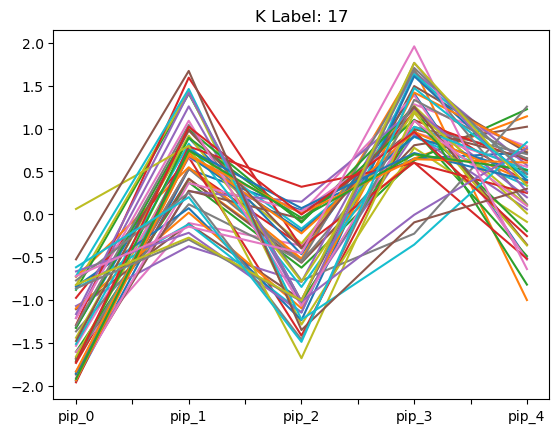

In [85]:
import random

m_k_label = random.choice(k_label_log_ratio_df.index)
k_label_sub_df = train_pips_y_df[train_pips_y_df['k_label'] == m_k_label]
for i in range(50):
    k_label_sub_df.iloc[i][['pip_0', 'pip_1', 'pip_2', 'pip_3', 'pip_4']].plot()
plt.title(f'K Label: {m_k_label}')
plt.show()

# TESTING THE MODEL

In [93]:
test_df = pd.read_csv("/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data/GBP_USD_M15_raw_data.csv", parse_dates=['time'])
test_df = test_df.set_index('time')
# take data from 2007 to 2014
test_df = test_df['2008-01-01':'2008-06-01']

# add new columns from the time column, year, month, day, hour, minute
test_df['year'] = test_df.index.year
test_df['month'] = test_df.index.month
test_df['day_of_week'] = test_df.index.day_of_week
test_df['hour'] = test_df.index.hour
test_df['minute'] = test_df.index.minute
test_df

n_close_points = 24
n_perc_points = 5
dist_measure = 1
pips_y_list = []
future_candles = 10
for index in range(n_close_points, len(test_df)):
    try:
        x_close = test_df['close'].iloc[index-n_close_points:index].to_numpy()
        pips_x, pips_y = find_pips(x_close, n_perc_points, dist_measure)
        scaled_pips_y = StandardScaler().fit_transform(np.array(pips_y).reshape(-1, 1)).reshape(-1)
        pips_y_dict = {f'pip_{i}': scaled_pips_y[i] for i in range(n_perc_points)}
        j = index - 1
        pips_y_dict['year'] = test_df['year'].iloc[j]
        pips_y_dict['month'] = test_df['month'].iloc[j]
        pips_y_dict['day_of_week'] = test_df['day_of_week'].iloc[j]
        pips_y_dict['hour'] = test_df['hour'].iloc[j]
        pips_y_dict['minute'] = test_df['minute'].iloc[j]
        pips_y_dict['close'] = test_df['close'].iloc[j]
        pips_y_dict['current_log_ratio'] = 2500 * np.log(pips_y_dict['close'] / test_df['close'].iloc[j-1])
        # future features
        pips_y_dict['future_close'] = test_df['close'].iloc[j+future_candles]
        pips_y_dict['future_return'] = pips_y_dict['future_close'] - pips_y_dict['close']
        pips_y_dict['future_log_ratio'] = 2500 * np.log(pips_y_dict['future_close'] / pips_y_dict['close'])
        pips_y_list.append(pips_y_dict)
    except:
        print('An exception occurred')
        break

pips_y_test_df = pd.DataFrame(pips_y_list)
pips_y_test_df_np = pips_y_test_df.to_numpy()

An exception occurred


In [94]:
np.random.seed(5)
# standard scale the 'hour', 'minute', 'current_log_ratio' columns
pips_y_test_df[['day_of_week', 'hour', 'minute']] = StandardScaler().fit_transform(pips_y_test_df[['day_of_week','hour', 'minute']])
pips_y_test_df_np = pips_y_test_df[['pip_0', 'pip_1', 'pip_2', 'pip_3', 'pip_4', 'day_of_week', 'hour', 'minute']].to_numpy()
y_test_pred = kmeans.predict(pips_y_test_df_np)
pips_y_test_df['k_label'] = y_test_pred
y_test_pips_df = pips_y_test_df.copy()
y_test_pips_df

,pip_0,pip_1,pip_2,pip_3,pip_4,year,month,day_of_week,hour,minute,close,current_log_ratio,future_close,future_return,future_log_ratio,k_label
0,0.183473,0.486703,1.523060,-1.144598,-1.048639,2008,1,-0.097075,-1.394720,0.446326,1.98270,0.063046,1.98800,0.00530,6.673890,16
1,0.098606,1.528399,0.501249,-1.327078,-0.801177,2008,1,-0.097075,-1.394720,1.340923,1.98373,1.298397,1.98860,0.00487,6.129907,16
2,0.092643,1.528189,0.484914,-1.372115,-0.733631,2008,1,-0.097075,-1.250628,-1.342867,1.98398,0.315043,1.98790,0.00392,4.934692,1
3,0.057042,1.521980,0.441642,-1.481359,-0.539305,2008,1,-0.097075,-1.250628,-0.448270,1.98463,0.818927,1.98825,0.00362,4.555890,1
4,0.219828,1.469828,0.392241,-1.525862,-0.556034,2008,1,-0.097075,-1.250628,0.446326,1.98470,0.088176,1.98640,0.00170,2.140465,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10578,-0.008751,-0.336912,0.720495,1.278369,-1.653201,2008,6,2.424022,1.198930,-0.448270,1.97427,0.633226,1.97482,0.00055,0.696363,3
10579,-0.279794,0.581568,0.474641,1.036012,-1.812426,2008,6,2.424022,1.198930,0.446326,1.97272,-1.963522,1.97332,0.00060,0.760256,5
10580,-0.019200,0.512010,0.396808,1.001620,-1.891237,2008,6,2.424022,1.198930,1.340923,1.97327,0.696910,1.97377,0.00050,0.633386,5
10581,-0.152757,0.509708,0.369421,1.105926,-1.832299,2008,6,2.424022,1.343022,-1.342867,1.97477,1.899677,1.97392,-0.00085,-1.076306,5


In [95]:
y_test_pips_grouped_df = y_test_pips_df.groupby('k_label')['future_log_ratio'].sum().sort_values(ascending=False)
y_test_pips_grouped_df

k_label
1     251.560063
7     171.114052
21    108.163731
11    106.958651
5     102.649865
32     96.587235
30     96.278447
31     79.285899
0      69.868713
23     68.995442
14     52.019304
29     39.630046
27     33.488325
19     29.949029
16     16.772970
20     16.612255
33      4.492866
15     -4.384926
6     -12.622180
22    -14.499718
10    -17.325619
25    -25.896698
24    -37.139682
26    -38.008153
13    -56.990921
4     -58.204424
35    -63.841320
12    -70.397304
28    -93.093918
8     -97.655837
2    -107.678922
9    -111.567381
17   -113.415756
34   -122.749142
3    -186.630333
18   -242.683388
Name: future_log_ratio, dtype: float64

## GRAPHS AND ILLUSTRATIONS

In [ ]:
# plot the histogram
pips_y_df.hist(bins=100)

In [ ]:
import ffn as ffn
import empyrical as ep

test_k_label = 14
test_pips_y_copy_df = train_pips_y_df[(train_pips_y_df['k_label'] == test_k_label)]
test_k_label_cumsum = test_pips_y_copy_df['future_log_ratio'].cumsum()
test_k_label_cumsum = test_k_label_cumsum.reset_index(drop=True)
test_k_label_cumsum.plot()

# Add a constant value to the series
test_k_label_cumsum = test_k_label_cumsum + 100
n_period = 252
# n_period = len(test_k_label_cumsum)
rf = 0.01

first_return = test_k_label_cumsum.iloc[0]
last_return = test_k_label_cumsum.iloc[-1]
annualized_return = (last_return/first_return) ** (1 / 1) - 1
annualized_std = test_k_label_cumsum.std()
ulcer_index = m_ulcer_index(test_k_label_cumsum)
max_drawdown = ffn.calc_max_drawdown(test_k_label_cumsum)
martin_ratio = (annualized_return*100 - rf) / ulcer_index
sharp_ratio = (annualized_return*100 - rf) / annualized_std
calmar_ratio = percent_return / abs(max_drawdown)
print("Calmar ratio:", calmar_ratio)
print("Annualized return:", annualized_return)
print("Annualized standard deviation:", annualized_std)
print("Ulcer index:", ulcer_index)
print("Martin ratio:", martin_ratio)
print("Max drawdown:", max_drawdown)
print("Sharp ratio:", sharp_ratio)

In [ ]:
np.random.seed(5)
# X = pips_y_df_np
X = pips_y_df_np[:700]

estimators = [
    ("k_means_24", KMeans(n_clusters=24)),
    ("k_means_3", KMeans(n_clusters=3)),
    ("k_means_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig = plt.figure(figsize=(13, 10))
titles = ["24 clusters", "3 clusters", "3 clusters, bad init"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_
    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("p0")
    ax.set_ylabel("p1")
    ax.set_zlabel("p2")
    ax.set_title(title)

plt.show()